# Local search - Flowshop problem

This notebook contains a hands-on the flowshop problem. We will focus on implementing some of the most known local search algorithms in order to solve this problem.

### Table of content
- [Neighborhood functions](#Neighborhood-functions)
- [Random walk](#Random-walk)
- [Hill climbing](#Hill-climbing)
    - [Simple Hill climbing](#Simple-hill-climbing)
    - [Steepest Ascent Hill climbing](#Steepest-ascent-hill-climbing)
    - [Stochastic Hill climbing](#Stochastic-hill-climbing)
- [Simulated annealing](#Simulated-annealing)
- [Tabu Search](#Tabu-Search)
- [VNS](#VNS)
- [Tests](#Tests)


### References
- [Benchmarks for Basic Scheduling Problems](http://mistic.heig-vd.ch/taillard/articles.dir/Taillard1993EJOR.pdf)
- [Introduction to Hill Climbing](https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/)
- [Implement Simulated annealing in Python](https://medium.com/swlh/how-to-implement-simulated-annealing-algorithm-in-python-ab196c2f56a0)
- [Tabu Search](https://medium.com/swlh/tabu-search-in-python-3199c44d44f1)

In [157]:
import numpy as np
import matplotlib as plt
import itertools
import time
import pandas as pd
import math
import random
from collections import deque
from itertools import combinations

In [158]:
def evaluate_sequence(sequence, processing_times):
    _, num_machines = processing_times.shape
    num_jobs = len(sequence)
    completion_times = np.zeros((num_jobs, num_machines))
    
    # Calculate the completion times for the first machine
    completion_times[0][0] = processing_times[sequence[0]][0]
    for i in range(1, num_jobs):
        completion_times[i][0] = completion_times[i-1][0] + processing_times[sequence[i]][0]
    
    # Calculate the completion times for the remaining machines
    for j in range(1, num_machines):
        completion_times[0][j] = completion_times[0][j-1] + processing_times[sequence[0]][j]
        for i in range(1, num_jobs):
            completion_times[i][j] = max(completion_times[i-1][j], completion_times[i][j-1]) + processing_times[sequence[i]][j]
    
    # Return the total completion time, which is the completion time of the last job in the last machine
    return completion_times[num_jobs-1][num_machines-1]

In [159]:
# Generate a random example to work with 7 jobs and 2 machines
rnd_data = np.random.randint(size=(15,10), low=5, high=120)
permutation = np.random.permutation(10).tolist()
print(rnd_data, "\n")
print('Initial solution:', permutation, "\n")

Cmax = evaluate_sequence(permutation, rnd_data)
print(f'Makespan: {Cmax}')

[[ 93  99  82  99   6  12  90 100  61  44]
 [ 96  14 108  91 111  60  67  94  74  17]
 [ 69  46  68  63  51  41  34  32   9 106]
 [ 80  68  32 119  54  73  14  16  48  46]
 [ 43  43  33  88  80  58 102  35  99  30]
 [104  54  13  23  41  21  87 112   5  15]
 [ 57 108  76 103  96  70  57   7  48  40]
 [ 28  99 114 116 119  42  24  83 105 103]
 [ 63  94  30  42  56  28  78  47  91 109]
 [ 60  25  22  40  53  22  30  38  79  49]
 [ 87  47  94  83  58  11  42  71  16  77]
 [ 88  75  75  98  22   8  73  14  99  59]
 [ 32  97  97  55  64  65  75  11  47  75]
 [ 94  28  51   9  69 101  79  72  97 105]
 [ 23  35   9  88  82  15  83  73  95  73]] 

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3] 

Makespan: 1497.0


# Neighborhood functions

#### Swap-based functions

In [160]:
def swap(solution, i, k):
    temp = solution[k]
    solution[k] = solution[i]
    solution[i] = temp
    return solution

In [161]:
def random_swap(solution, processing_times):
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    # Generating two different random positions
    while (i == k):
        k = np.random.choice(list(solution))
    # Switch between job i and job k in the given sequence
    neighbor = solution.copy()
    return swap(neighbor, i, k), evaluate_sequence(neighbor, processing_times)

In [162]:
neighbor, neighbor_cmax = random_swap(permutation, rnd_data)

print("Original solution:", permutation)
print("Makespan: ", Cmax)

print("\nNeighboor solution:", neighbor)
print("Makespan:", neighbor_cmax)

Original solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan:  1497.0

Neighboor solution: [5, 6, 9, 0, 4, 2, 1, 7, 8, 3]
Makespan: 1614.0


In [163]:
def best_first_swap(solution, processing_times):
    # This function will take a solution, and return the first best solution.
    # The first solution that is better then the current one 'solution' in args.
    num_jobs = len(solution)
    best_cmax = evaluate_sequence(solution, processing_times)
    best_neighbor = solution.copy()
    for k1 in range(num_jobs):
        for k2 in range(k1+1, num_jobs):
            neighbor = solution.copy()
            neighbor = swap(neighbor,k1,k2)
            cmax = evaluate_sequence(neighbor, processing_times)
            if cmax < best_cmax:
                best_neighbor = neighbor
                best_cmax = cmax
                return best_neighbor, best_cmax
    return best_neighbor, best_cmax

In [164]:
neighbor, neighbor_cmax = best_first_swap(permutation, rnd_data)

print("Original solution:", permutation)
print("Makespan:", Cmax)

print("\nNeighboor solution:", neighbor)
print("Makespan:", neighbor_cmax)

Original solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Neighboor solution: [6, 5, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1454.0


In [165]:
def best_swap(solution, processing_times):
    # This function will take a solution, and return its best neighbor solution.
    num_jobs = len(solution)
    best_cmax = np.Infinity
    for k1 in range(num_jobs):
        for k2 in range(k1+1, num_jobs):
            neighbor = solution.copy()
            neighbor = swap(neighbor,k1,k2)
            cmax = evaluate_sequence(neighbor, processing_times)
            if cmax < best_cmax:
                best_neighbor = neighbor
                best_cmax = cmax
    return best_neighbor, best_cmax

In [166]:
neighbor, neighbor_cmax = best_swap(permutation, rnd_data)

print("Original solution:", permutation)
print("Makespan:", Cmax)

print("\nNeighboor solution:", neighbor)
print("Makespan:", neighbor_cmax)

Original solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Neighboor solution: [4, 6, 9, 8, 5, 2, 1, 7, 0, 3]
Makespan: 1424.0


In [167]:
def best_swaps(solution, processing_times):
    # This function will take a solution, and return a list that contains all solutions that are better than it.
    num_jobs = len(solution)
    cmax = evaluate_sequence(solution, processing_times)
    bests = []
    for k1 in range(num_jobs):
        for k2 in range(k1+1, num_jobs):
            neighbor = solution.copy()
            swap(neighbor,k1,k2)
            neighbor_cmax = evaluate_sequence(neighbor, processing_times)
            if neighbor_cmax < cmax:
                bests.append((neighbor_cmax, neighbor))
    bests.sort(key=lambda x: x[0])
    return bests

In [168]:
bests = best_swaps(permutation, rnd_data)

print("Original solution:", permutation)
print("Makespan:", Cmax)

print("\n\nBetter Neighboors:", bests)

Original solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0


Better Neighboors: [(1424.0, [4, 6, 9, 8, 5, 2, 1, 7, 0, 3]), (1453.0, [3, 6, 9, 8, 4, 2, 1, 7, 0, 5]), (1454.0, [6, 5, 9, 8, 4, 2, 1, 7, 0, 3]), (1464.0, [5, 3, 9, 8, 4, 2, 1, 7, 0, 6]), (1470.0, [9, 6, 5, 8, 4, 2, 1, 7, 0, 3]), (1478.0, [8, 6, 9, 5, 4, 2, 1, 7, 0, 3]), (1478.0, [5, 6, 9, 8, 4, 1, 2, 7, 0, 3]), (1487.0, [5, 6, 9, 8, 1, 2, 4, 7, 0, 3])]


#### Insertion-based functions

In [169]:
def random_insertion(solution, processing_times):
    # This function consists of choosing random two indices, i and k.
    # Remove the element at indice i, and insert it in the position k.
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    while (i == k):
        k = np.random.choice(list(solution))
    neighbor = solution.copy()
    neighbor.remove(solution[i])
    neighbor.insert(k, solution[i])
    return neighbor, evaluate_sequence(neighbor, processing_times)

In [170]:
neighbor, neighbor_cmax = random_insertion(permutation, rnd_data)

print("Original solution:", permutation)
print("Makespan:", Cmax)

print("\nNeighboor solution:", neighbor)
print("Makespan:", neighbor_cmax)

Original solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Neighboor solution: [5, 6, 9, 4, 8, 2, 1, 7, 0, 3]
Makespan: 1497.0


In [171]:
def best_insertion(solution, processing_times):
    # This function consists of trying all different insertions.
    # Then it returns the best one among them
    num_jobs = len(solution)
    best_cmax = np.Infinity
    for k1 in range(num_jobs):
        s = solution.copy()
        s_job = solution[k1]
        s.remove(s_job)
        for k2 in range(num_jobs):
            if k1 != k2:
                neighbor = s.copy()
                neighbor.insert(k2, s_job)
                cmax = evaluate_sequence(neighbor, processing_times)
                if cmax < best_cmax:
                    best_neighbor = neighbor
                    best_cmax = cmax
    return best_neighbor, best_cmax

In [172]:
neighbor, neighbor_cmax = best_insertion(permutation, rnd_data)

print("Original solution:", permutation)
print("Makespan:", Cmax)

print("\nNeighboor solution:", neighbor)
print("Makespan:", neighbor_cmax)

Original solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Neighboor solution: [6, 9, 8, 4, 2, 1, 7, 0, 3, 5]
Makespan: 1408.0


In [173]:
def best_edge_insertion(solution, processing_times):
    num_jobs = len(solution)
    best_cmax = np.Infinity
    for k1 in range(num_jobs-1):
        s = solution.copy()
        s_job1 = s[k1] 
        s_job2 = s[k1+1]
        s.remove(s_job1)
        s.remove(s_job2)
        for k2 in range(num_jobs-1):
            if(k1 != k2):
                neighbor = s.copy()
                neighbor.insert(k2, s_job1)
                neighbor.insert(k2+1, s_job2)
                cmax = evaluate_sequence(neighbor, processing_times)
                if cmax < best_cmax:
                    best_neighbor = neighbor
                    best_cmax = cmax
    return best_neighbor, best_cmax

In [174]:
neighbor, neighbor_cmax = best_edge_insertion(permutation, rnd_data)

print("Original solution:", permutation)
print("Makespan:", Cmax)

print("\nNeighboor solution:", neighbor)
print("Makespan:", neighbor_cmax)

Original solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Neighboor solution: [9, 8, 4, 2, 1, 7, 0, 5, 6, 3]
Makespan: 1349.0


# Random walk

In [175]:
def random_walk(solution, processing_times, nb_iter=1000, threshold=None):
    x = solution
    cmax = evaluate_sequence(solution, processing_times)
    iterations = 0
    while iterations < nb_iter:
        x, cmax = random_swap(x, processing_times)
        if threshold is not None and cmax < threshold:
            return x, cmax, iterations
        iterations += 1
    return x, cmax, iterations

In [176]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
neighbor, neighbor_cmax, iterations = random_walk(permutation, rnd_data, threshold=1450)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", neighbor)
print("Makespan:", neighbor_cmax)
print("Number of iterations:", iterations)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [7, 4, 9, 8, 6, 2, 1, 3, 0, 5]
Makespan: 1397.0
Number of iterations: 2

Elapsed time: 0.001994609832763672 seconds


# Hill climbing

## Simple Hill climbing

It examines the neighboring nodes and selects the first neighboring node which optimizes the current cost as the next node.

In [177]:
def simple_hill_climbing(solution, processing_times, nb_iter=10000):
    x = solution
    cmax = evaluate_sequence(solution, processing_times)
    iterations = 0
    while iterations < nb_iter:
        best_neighbor, best_cmax  = best_first_swap(x, processing_times)
        if best_cmax == cmax:
            return best_neighbor, best_cmax, iterations
        x = best_neighbor
        cmax = best_cmax
        iterations += 1
    return x, cmax, iterations

In [178]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax, nb_iterations = simple_hill_climbing(permutation, rnd_data)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("Number of iterations:", iterations)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [8, 9, 2, 4, 1, 7, 0, 5, 6, 3]
Makespan: 1324.0
Number of iterations: 2

Elapsed time: 0.07110452651977539 seconds


## Steepest Ascent Hill climbing

It examines the neighboring nodes one by one and selects the best neighboring node which optimizes the current cost as the next node.

In [179]:
def steepest_ascent_hill_climbing(solution, processing_times, nb_iter=1000):
    x = solution
    cmax = evaluate_sequence(solution, processing_times)
    iterations = 0
    while iterations < nb_iter:
        best_neighbor, best_cmax = best_swap(solution, processing_times)
        if best_cmax > cmax:
            return x, cmax
        else:
            x = best_neighbor
            cmax = best_cmax
            iterations += 1
    return best_neighbor, best_cmax, iterations

In [180]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax, nb_iterations = steepest_ascent_hill_climbing(permutation, rnd_data)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("Number of iterations:", nb_iterations)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [4, 6, 9, 8, 5, 2, 1, 7, 0, 3]
Makespan: 1424.0
Number of iterations: 1000

Elapsed time: 6.898458480834961 seconds


## Stochastic Hill climbing

Among the generated neighbor states which are better than the current state, It chooses a state randomly (or based on some probability function).

In [181]:
def stochastic_hill_climbing(solution, processing_times, nb_iter=1000):
    x = solution
    cmax = evaluate_sequence(solution, processing_times)
    iterations = 0
    while iterations < nb_iter:
        best_neighbours  = best_swaps(x, processing_times)
        if len(best_neighbours) == 0:
            return x, cmax, iterations
        i = random.randint(0,len(best_neighbours) - 1)
        best_cmax, best_neighbor = best_neighbours[i]
        if best_cmax > cmax:
            return x, cmax, iterations
        x = best_neighbor
        cmax = best_cmax
        iterations += 1
    return best_neighbor, best_cmax, iterations

In [182]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax, nb_iterations = stochastic_hill_climbing(permutation, rnd_data)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("Number of iterations:", nb_iterations)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [2, 4, 7, 8, 3, 5, 9, 1, 0, 6]
Makespan: 1391.0
Number of iterations: 5

Elapsed time: 0.05128741264343262 seconds


# Simulated annealing

In [183]:
def get_neighbor(solution, processing_times, method="random_swap"):
    # Swapping methods
    if method == "random_swap":
        neighbor, cost = random_swap(solution, processing_times)
    elif method == "best_swap":
        neighbor, cost = best_swap(solution, processing_times)
    elif method == "best_first_swap":
        neighbor, cost = best_first_swap(solution, processing_times)
    # Insertion methods
    elif method == "random_insertion":
        neighbor, cost = random_insertion(solution, processing_times)
    elif method == "best_edge_insertion":
        neighbor, cost = best_edge_insertion(solution, processing_times)
    elif method == "best_insertion":
        neighbor, cost = best_insertion(solution, processing_times)
    # Randomly pick a method of generating neighbors.
    else:     
        i = random.randint(0, 5)
        if i == 0:
            neighbor, cost = random_swap(solution, processing_times)
        elif i == 1:
            neighbor, cost = best_swap(solution, processing_times)
        elif i == 2:
            neighbor, cost = best_first_swap(solution, processing_times)
        elif i == 3:
            neighbor, cost = random_insertion(solution, processing_times)
        elif i == 4:
            neighbor, cost = best_edge_insertion(solution, processing_times)
        else:
            neighbor, cost = best_insertion(solution, processing_times)
    return neighbor, cost

In [184]:
def simulated_annealing(initial_solution, processing_times, method="random", initial_temp=100, final_temp=1, alpha=0.1):
    current_temp = initial_temp
    current_solution = initial_solution.copy()
    current_cost = evaluate_sequence(initial_solution, processing_times)
    while current_temp > final_temp:
        neighbor, neighbor_cost  = get_neighbor(current_solution, processing_times, method)
        cost_diff = current_cost - neighbor_cost
        if cost_diff > 0:
            current_solution = neighbor
            current_cost = neighbor_cost
        else:
            if random.uniform(0, 1) < math.exp(-cost_diff / current_temp):
                solution = neighbor
        current_temp -= alpha
    return current_solution, current_cost

In [185]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax = simulated_annealing(permutation, rnd_data, method="random_insertion")
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [4, 6, 8, 1, 2, 9, 7, 3, 0, 5]
Makespan: 1346.0

Elapsed time: 0.22452425956726074 seconds


In [186]:
# In this test, the method is set to random, so at each iteration we choose a different function for generating the next neighbor
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax = simulated_annealing(permutation, rnd_data)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [4, 6, 8, 1, 2, 9, 7, 0, 3, 5]
Makespan: 1346.0

Elapsed time: 6.292591094970703 seconds


In [187]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax = simulated_annealing(permutation, rnd_data, method="best_swap")
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [4, 7, 8, 9, 0, 2, 1, 3, 5, 6]
Makespan: 1317.0

Elapsed time: 6.840753078460693 seconds


# Tabu Search

In [188]:
def tabu_search(initial_solution, processing_times, nb_iter=1000):
    tabu_list = deque(maxlen=15)
    best_solution = initial_solution.copy()
    best_cmax = evaluate_sequence(initial_solution, processing_times)
    iterations = 0
    while iterations < nb_iter:
        neighbours = best_swaps(best_solution, processing_times)
        # If we don't have any best neighboors, we generate one randomly
        if len(neighbours):
            best_solution = random_swap(best_solution, processing_times)
        # We check for neighbours
        for neighbour in neighbours:
            if neighbour[1] not in tabu_list:
                best_solution = neighbour[1]
                best_cmax = neighbour[0]
                tabu_list.append(neighbour[1])
                break
            # If It is in the tabu list we would look for the next neighbor
            else:
                continue
        iterations += 1
    return best_solution, best_cmax, iterations

In [189]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax, iterations = tabu_search(permutation, rnd_data)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [4, 7, 8, 9, 0, 2, 1, 3, 5, 6]
Makespan: 1317.0

Elapsed time: 7.935917854309082 seconds


# VNS

In [190]:
# This function performs a random perturbation on a list by swapping the elements of k adjacent positions.
# solution: the list to be perturbed
# k: the number of adjacent positions to be swapped
def shake(solution, k):
    n = len(solution)
    # If k is greater than the length of the list, then we create perturbations on all elements.
    indices = random.sample(range(n), min(k, n-1))
    indices.sort()
    neighbor = solution.copy()
    for i in indices:
        j = (i+k) % n
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

In [211]:
def vns(sol_init, processing_times, max_iterations, k_max):
    num_jobs = len(sol_init)
    current_solution = sol_init
    current_cost = evaluate_sequence(current_solution, processing_times)
    k = 1
    iteration = 0
    while iteration < max_iterations:       
        # Appliquer la perturbation "shake" pour générer le voisin aléatoire
        best_neighbor_solution = shake(current_solution, k)
        best_neighbor_cost = evaluate_sequence(best_neighbor_solution, processing_times)
        
        # Parcourir les voisins pour trouver la meilleure solution locale
        for l in range(1, k_max+1):
            neighbor, neighbor_cost  = get_neighbor(current_solution, processing_times, method="random")
            if (neighbor_cost < best_neighbor_cost):
                best_neighbor_solution = neighbor
                best_neighbor_cost = neighbor_cost            
        
        # Si la meilleure solution trouvée dans le voisinage est meilleure que la solution courante
        # alors on met à jour la solution courante et on réinitialise le rayon de la recherche
        if ( best_neighbor_cost < current_cost ):
            current_solution = best_neighbor_solution
            current_cost = best_neighbor_cost
            k = 1
        else:
            k += 1
        iteration += 1
    return current_solution, current_cost

In [192]:
# For 100 iterations, and k set to 5
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax = vns(permutation, rnd_data, 100, 5)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [4, 9, 7, 0, 2, 8, 1, 3, 5, 6]
Makespan: 1318.0

Elapsed time: 0.14304304122924805 seconds


In [193]:
# For 1000 iterations, and k set to 10
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax = vns(permutation, rnd_data, 1000, 10)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [5, 6, 9, 8, 4, 2, 1, 7, 0, 3]
Makespan: 1497.0

Generated solution: [4, 6, 9, 8, 1, 2, 7, 3, 0, 5]
Makespan: 1352.0

Elapsed time: 2.0959348678588867 seconds


# Tests

## Heuristics

### NEH Heuristic

In [82]:
def order_jobs_in_descending_order_of_total_completion_time(processing_times):
    total_completion_time = processing_times.sum(axis=1)
    return np.argsort(total_completion_time, axis=0).tolist()

In [83]:
def insertion(sequence, position, value):
    new_seq = sequence[:]
    new_seq.insert(position, value)
    return new_seq

In [84]:
def neh_algorithm(processing_times):
    ordered_sequence = order_jobs_in_descending_order_of_total_completion_time(processing_times)
    # Define the initial order
    J1, J2 = ordered_sequence[:2]
    sequence = [J1, J2] if evaluate_sequence([J1, J2], processing_times) < evaluate_sequence([J2, J1], processing_times) else [J2, J1]
    del ordered_sequence[:2]
    # Add remaining jobs
    for job in ordered_sequence:
        Cmax = float('inf')
        best_sequence = []
        for i in range(len(sequence)+1):
            new_sequence = insertion(sequence, i, job)
            Cmax_eval = evaluate_sequence(new_sequence, processing_times)
            if Cmax_eval < Cmax:
                Cmax = Cmax_eval
                best_sequence = new_sequence
        sequence = best_sequence
    return sequence, Cmax

## Reading Taillard Instances

### Taillard, 20 jobs 5 machines

In [80]:
# Open the file that contains the instances
file = open("Benchmarks/tai20_5.txt", "r")

# Read the file line by line to retrieve the instances
n = 0
instances_20_5 = [[]]
line = file.readline()

while line:
    if line != '\n':
        line = line.strip(' ')
        line = line[:-1]
        line = line.split()
        line = [int(num) for num in line]
        instances_20_5[n].append(line)
    else:
        instances_20_5.append([])
        n += 1
    line = file.readline()
    
print(f'Taillard, 20 jobs 5 machines contains {len(instances_20_5)} benchmark.')   

Taillard, 20 jobs 5 machines contains 10 benchmark.


### Taillard, 50 jobs 10 machines

In [81]:
# Open the file that contains the instances
file = open("Benchmarks/tai50_10.txt", "r")

# Read the file line by line to retrieve the instances
n = 0
instances_50_10 = [[]]
line = file.readline()

while line:
    if line != '\n':
        line = line.strip(' ')
        line = line[:-1]
        line = line.split()
        line = [int(num) for num in line]
        instances_50_10[n].append(line)
    else:
        instances_50_10.append([])
        n += 1
    line = file.readline()
    
print(f'Taillard, 50 jobs 10 machines contains {len(instances_50_10)} benchmark.')

Taillard, 50 jobs 10 machines contains 10 benchmark.


## Running the tests

In [97]:
# Prepare dataframes that will gather all our results
df_random = pd.DataFrame({'Metaheuristic': pd.Series(dtype='str'),
                   '20-5-1 (Makespan)': pd.Series(dtype='str'),
                   '20-5-1 (Time)': pd.Series(dtype='str'),
                   '20-5-7 (Makespan)': pd.Series(dtype='str'),
                   '20-5-7 (Time)': pd.Series(dtype='str'),
                  }) 
df_neh = pd.DataFrame({'Metaheuristic': pd.Series(dtype='str'),
                   '20-5-1 (Makespan)': pd.Series(dtype='str'),
                   '20-5-1 (Time)': pd.Series(dtype='str'),
                   '20-5-7 (Makespan)': pd.Series(dtype='str'),
                   '20-5-7 (Time)': pd.Series(dtype='str'),
                  }) 

In [98]:
RW_random = ['Random Walk']
HC1_random = ['Simple Hill climbing']
HC2_random = ['Steepest Ascent Hill climbing']
HC3_random = ['Stochastic Hill climbing']
SA_random = ['Simulated annealing']
TS_random = ['Tabu Search']
VNS_random = ['VNS']

In [99]:
RW_neh = ['Random Walk']
HC1_neh = ['Simple Hill climbing']
HC2_neh = ['Steepest Ascent Hill climbing']
HC3_neh = ['Stochastic Hill climbing']
SA_neh = ['Simulated annealing']
TS_neh = ['Tabu Search']
VNS_neh = ['VNS']

In [104]:
instance_1 = np.array(instances_20_5[0])
instance_1 = instance_1.T
neh_20_5_1, cmax_20_5_1 = neh_algorithm(instance_1)
print(cmax_20_5_1)

1334.0


In [105]:
instance_7 = np.array(instances_20_5[6])
instance_7 = instance_7.T
neh_20_5_7, cmax_20_5_7 = neh_algorithm(instance_7)
print(cmax_20_5_7)

1284.0


### Random walk

In [136]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_1)}')
start_time = time.time()
sol, Cmax, _ = random_walk(rnd_solution, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

RW_random.append("%.3f" % (Cmax))
RW_random.append(" %.3fs" % (elapsed_time))

Original Solution: [3, 6, 12, 4, 7, 17, 8, 18, 19, 11, 15, 16, 1, 14, 0, 13, 9, 10, 5, 2].
Makespan: 1503.0


Generated Solution: [18, 12, 11, 14, 6, 5, 2, 16, 10, 17, 7, 3, 9, 15, 1, 8, 0, 13, 4, 19].
Makespan: 1485.0

Elapsed time:  0.20685696601867676 seconds


In [137]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_7)}')
start_time = time.time()
sol, Cmax, _ = random_walk(rnd_solution, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

RW_random.append("%.3f" % (Cmax))
RW_random.append(" %.3fs" % (elapsed_time))

Original Solution: [18, 7, 5, 17, 1, 8, 2, 13, 16, 6, 4, 10, 14, 3, 12, 9, 0, 19, 15, 11].
Makespan: 1495.0


Generated Solution: [8, 12, 5, 3, 1, 18, 15, 19, 13, 17, 14, 0, 2, 9, 7, 16, 4, 6, 11, 10].
Makespan: 1509.0

Elapsed time:  0.17856240272521973 seconds


In [237]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax, _ = random_walk(neh_20_5_1, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

RW_neh.append("%.3f" % (Cmax))
RW_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [5, 16, 18, 15, 17, 12, 10, 1, 0, 7, 2, 14, 6, 11, 9, 8, 3, 4, 19, 13].
Makespan: 1422.0

Elapsed time:  0.21238231658935547 seconds


In [238]:
print(f'NEH Solution: {neh_20_5_7}.')
print(f'Makespan: {cmax_20_5_7}')
start_time = time.time()
sol, Cmax, _ = random_walk(neh_20_5_7, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

RW_neh.append("%.3f" % (Cmax))
RW_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].
Makespan: 1284.0


Generated Solution: [13, 18, 8, 11, 19, 15, 14, 17, 2, 5, 3, 1, 0, 4, 7, 9, 6, 10, 16, 12].
Makespan: 1476.0

Elapsed time:  0.20998215675354004 seconds


### Hill climbing

#### Simple

In [145]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_1)}')
start_time = time.time()
sol, Cmax, _ = simple_hill_climbing(rnd_solution, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC1_random.append("%.3f" % (Cmax))
HC1_random.append(" %.3fs" % (elapsed_time))

Original Solution: [5, 15, 18, 8, 16, 14, 19, 1, 11, 13, 7, 0, 10, 12, 2, 4, 6, 9, 17, 3].
Makespan: 1511.0


Generated Solution: [12, 5, 18, 8, 16, 14, 17, 13, 11, 3, 1, 0, 4, 15, 7, 10, 6, 9, 19, 2].
Makespan: 1323.0

Elapsed time:  0.2649540901184082 seconds


In [146]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_7)}')
start_time = time.time()
sol, Cmax, _ = simple_hill_climbing(rnd_solution, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC1_random.append("%.3f" % (Cmax))
HC1_random.append(" %.3fs" % (elapsed_time))

Original Solution: [14, 10, 16, 13, 9, 15, 19, 17, 11, 6, 0, 1, 4, 5, 2, 8, 3, 18, 7, 12].
Makespan: 1505.0


Generated Solution: [4, 14, 19, 10, 6, 3, 12, 8, 0, 5, 16, 1, 15, 13, 2, 9, 11, 18, 7, 17].
Makespan: 1262.0

Elapsed time:  0.1772928237915039 seconds


In [147]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax, _ = simple_hill_climbing(neh_20_5_1, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC1_neh.append("%.3f" % (Cmax))
HC1_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  0.0866696834564209 seconds


In [148]:
print(f'NEH Solution: {neh_20_5_7}.')
print(f'Makespan: {cmax_20_5_7}')
start_time = time.time()
sol, Cmax, _ = simple_hill_climbing(neh_20_5_7, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC1_neh.append("%.3f" % (Cmax))
HC1_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].
Makespan: 1284.0


Generated Solution: [4, 15, 19, 10, 7, 16, 3, 8, 1, 12, 6, 18, 5, 11, 2, 14, 0, 17, 13, 9].
Makespan: 1251.0

Elapsed time:  0.12863445281982422 seconds


#### Steepest Ascent

In [149]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_1)}')
start_time = time.time()
sol, Cmax, _ = steepest_ascent_hill_climbing(rnd_solution, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC2_random.append("%.3f" % (Cmax))
HC2_random.append(" %.3fs" % (elapsed_time))

Original Solution: [11, 16, 14, 0, 3, 2, 8, 10, 18, 19, 12, 1, 5, 7, 9, 4, 6, 13, 17, 15].
Makespan: 1474.0


Generated Solution: [11, 16, 14, 0, 3, 2, 8, 10, 18, 15, 12, 1, 5, 7, 9, 4, 6, 13, 17, 19].
Makespan: 1385.0

Elapsed time:  27.873820066452026 seconds


In [150]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_7)}')
start_time = time.time()
sol, Cmax, _ = steepest_ascent_hill_climbing(rnd_solution, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC2_random.append("%.3f" % (Cmax))
HC2_random.append(" %.3fs" % (elapsed_time))

Original Solution: [0, 7, 18, 4, 12, 16, 10, 14, 2, 19, 13, 11, 6, 5, 8, 9, 3, 15, 17, 1].
Makespan: 1452.0


Generated Solution: [0, 7, 18, 4, 12, 16, 10, 14, 2, 19, 13, 11, 6, 5, 8, 1, 3, 15, 17, 9].
Makespan: 1392.0

Elapsed time:  28.596442461013794 seconds


In [151]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax, _ = steepest_ascent_hill_climbing(neh_20_5_1, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC2_neh.append("%.3f" % (Cmax))
HC2_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 6, 19].
Makespan: 1331.0

Elapsed time:  28.401727437973022 seconds


In [152]:
print(f'NEH Solution: {neh_20_5_7}.')
print(f'Makespan: {cmax_20_5_7}')
start_time = time.time()
sol, Cmax, _ = steepest_ascent_hill_climbing(neh_20_5_7, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC2_neh.append("%.3f" % (Cmax))
HC2_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].
Makespan: 1284.0


Generated Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 11, 14, 15, 0, 17, 13, 9].
Makespan: 1280.0

Elapsed time:  28.897857427597046 seconds


#### Stochastic

In [195]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_1)}')
start_time = time.time()
sol, Cmax, _ = stochastic_hill_climbing(rnd_solution, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC3_random.append("%.3f" % (Cmax))
HC3_random.append(" %.3fs" % (elapsed_time))

Original Solution: [19, 14, 15, 17, 10, 18, 8, 0, 1, 5, 2, 7, 13, 6, 16, 11, 4, 12, 3, 9].
Makespan: 1457.0


Generated Solution: [2, 14, 15, 13, 10, 18, 8, 5, 7, 0, 12, 16, 3, 4, 17, 11, 1, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  0.33051371574401855 seconds


In [196]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_7)}')
start_time = time.time()
sol, Cmax, _ = stochastic_hill_climbing(rnd_solution, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC3_random.append("%.3f" % (Cmax))
HC3_random.append(" %.3fs" % (elapsed_time))

Original Solution: [19, 18, 4, 6, 14, 15, 0, 2, 13, 5, 1, 9, 16, 3, 8, 12, 10, 17, 7, 11].
Makespan: 1499.0


Generated Solution: [4, 10, 15, 5, 2, 19, 7, 14, 1, 12, 13, 11, 6, 3, 8, 16, 18, 0, 17, 9].
Makespan: 1251.0

Elapsed time:  0.42995691299438477 seconds


In [197]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax, _ = stochastic_hill_climbing(neh_20_5_1, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC3_neh.append("%.3f" % (Cmax))
HC3_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  0.09839677810668945 seconds


In [198]:
print(f'NEH Solution: {neh_20_5_7}.')
print(f'Makespan: {cmax_20_5_7}')
start_time = time.time()
sol, Cmax, _ = stochastic_hill_climbing(neh_20_5_7, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

HC3_neh.append("%.3f" % (Cmax))
HC3_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].
Makespan: 1284.0


Generated Solution: [4, 15, 1, 10, 7, 18, 3, 11, 19, 12, 16, 5, 6, 8, 14, 2, 0, 17, 13, 9].
Makespan: 1251.0

Elapsed time:  0.20838570594787598 seconds


### Simulated Annealing

> As shown above, we implemented several methods for generating the next neighbor for SA. Below, the chosen method is the method "best_swap". Which takes more time than "random_swap" or "random_insertion"

In [199]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_1)}')
start_time = time.time()
sol, Cmax = simulated_annealing(rnd_solution, instance_1, method="best_swap")
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

SA_random.append("%.3f" % (Cmax))
SA_random.append(" %.3fs" % (elapsed_time))

Original Solution: [9, 4, 18, 16, 15, 14, 2, 13, 5, 12, 8, 0, 1, 10, 3, 6, 7, 17, 11, 19].
Makespan: 1431.0


Generated Solution: [5, 3, 18, 16, 15, 14, 2, 13, 7, 12, 8, 0, 1, 10, 4, 6, 17, 11, 9, 19].
Makespan: 1297.0

Elapsed time:  26.560821056365967 seconds


In [201]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_7)}')
start_time = time.time()
sol, Cmax = simulated_annealing(rnd_solution, instance_7, method="best_swap")
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

SA_random.append("%.3f" % (Cmax))
SA_random.append(" %.3fs" % (elapsed_time))

Original Solution: [0, 13, 12, 3, 4, 8, 5, 1, 17, 14, 7, 10, 6, 16, 11, 9, 15, 18, 2, 19].
Makespan: 1431.0


Generated Solution: [4, 10, 14, 3, 0, 12, 5, 1, 2, 19, 7, 8, 6, 16, 11, 13, 15, 18, 17, 9].
Makespan: 1251.0

Elapsed time:  27.609627723693848 seconds


In [202]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax = simulated_annealing(neh_20_5_1, instance_1, method="best_swap")
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

SA_neh.append("%.3f" % (Cmax))
SA_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  27.970661163330078 seconds


In [203]:
print(f'NEH Solution: {neh_20_5_7}.')
print(f'Makespan: {cmax_20_5_7}')
start_time = time.time()
sol, Cmax = simulated_annealing(neh_20_5_7, instance_7, method="best_swap")
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

SA_neh.append("%.3f" % (Cmax))
SA_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].
Makespan: 1284.0


Generated Solution: [4, 15, 19, 10, 7, 16, 3, 8, 1, 12, 6, 18, 5, 11, 14, 2, 0, 17, 13, 9].
Makespan: 1251.0

Elapsed time:  25.21662950515747 seconds


### Tabu Search

In [230]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_1)}')
start_time = time.time()
sol, Cmax, _ = tabu_search(rnd_solution, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

TS_random.append("%.3f" % (Cmax))
TS_random.append(" %.3fs" % (elapsed_time))

Original Solution: [3, 14, 1, 11, 5, 10, 9, 15, 2, 6, 16, 8, 4, 12, 13, 0, 18, 17, 7, 19].
Makespan: 1412.0


Generated Solution: [14, 5, 2, 15, 12, 10, 7, 0, 1, 6, 16, 8, 4, 3, 17, 11, 18, 13, 9, 19].
Makespan: 1297.0

Elapsed time:  26.501147747039795 seconds


In [231]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_7)}')
start_time = time.time()
sol, Cmax, _ = tabu_search(rnd_solution, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

TS_random.append("%.3f" % (Cmax))
TS_random.append(" %.3fs" % (elapsed_time))

Original Solution: [0, 12, 5, 17, 7, 18, 6, 8, 19, 2, 3, 15, 11, 1, 9, 16, 10, 4, 14, 13].
Makespan: 1444.0


Generated Solution: [10, 12, 19, 0, 7, 18, 6, 8, 5, 2, 3, 15, 11, 1, 13, 16, 17, 4, 14, 9].
Makespan: 1285.0

Elapsed time:  26.213616132736206 seconds


In [242]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax, _ = tabu_search(neh_20_5_1, instance_1)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

TS_neh.append("%.3f" % (Cmax))
TS_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  27.079190254211426 seconds


In [243]:
print(f'NEH Solution: {neh_20_5_7}.')
print(f'Makespan: {cmax_20_5_7}')
start_time = time.time()
sol, Cmax, _ = tabu_search(neh_20_5_7, instance_7)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

TS_neh.append("%.3f" % (Cmax))
TS_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].
Makespan: 1284.0


Generated Solution: [4, 15, 19, 10, 7, 16, 3, 8, 1, 12, 6, 18, 5, 11, 14, 2, 0, 17, 13, 9].
Makespan: 1251.0

Elapsed time:  27.07159948348999 seconds


### VNS

In [228]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_1)}')
start_time = time.time()
sol, Cmax = vns(rnd_solution, instance_1, 100, 5)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS_random.append("%.3f" % (Cmax))
VNS_random.append(" %.3fs" % (elapsed_time))

Original Solution: [16, 9, 8, 4, 14, 18, 13, 17, 19, 7, 0, 2, 10, 11, 15, 3, 6, 5, 12, 1].
Makespan: 1542.0


Generated Solution: [5, 3, 8, 4, 14, 15, 0, 17, 13, 16, 7, 18, 6, 10, 2, 1, 12, 11, 9, 19].
Makespan: 1297.0

Elapsed time:  0.13280415534973145 seconds


In [229]:
rnd_solution = list(range(20))
random.shuffle(rnd_solution)

print(f'Original Solution: {rnd_solution}.')
print(f'Makespan: {evaluate_sequence(rnd_solution, instance_7)}')
start_time = time.time()
sol, Cmax = vns(rnd_solution, instance_7, 100, 5)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS_random.append("%.3f" % (Cmax))
VNS_random.append(" %.3fs" % (elapsed_time))

Original Solution: [19, 11, 9, 10, 4, 12, 18, 0, 13, 5, 3, 8, 1, 16, 15, 6, 17, 14, 2, 7].
Makespan: 1481.0


Generated Solution: [4, 14, 0, 18, 19, 7, 5, 12, 13, 1, 3, 2, 15, 16, 10, 17, 11, 6, 8, 9].
Makespan: 1252.0

Elapsed time:  0.12657928466796875 seconds


In [247]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax = vns(neh_20_5_1, instance_1, 100, 5)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS_neh.append("%.3f" % (Cmax))
VNS_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  0.13494634628295898 seconds


In [248]:
print(f'NEH Solution: {neh_20_5_7}.')
print(f'Makespan: {cmax_20_5_7}')
start_time = time.time()
sol, Cmax = vns(neh_20_5_7, instance_7, 100, 5)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

VNS_neh.append("%.3f" % (Cmax))
VNS_neh.append(" %.3fs" % (elapsed_time))

NEH Solution: [4, 2, 19, 10, 7, 5, 3, 8, 1, 12, 6, 18, 16, 9, 14, 15, 0, 17, 13, 11].
Makespan: 1284.0


Generated Solution: [4, 14, 19, 10, 7, 15, 3, 0, 1, 12, 16, 18, 6, 2, 9, 5, 8, 11, 13, 17].
Makespan: 1259.0

Elapsed time:  0.13113856315612793 seconds


### Results

In [232]:
df_random.loc[0]=RW_random
df_random.loc[1]=HC1_random
df_random.loc[2]=HC2_random
df_random.loc[3]=HC3_random
df_random.loc[4]=SA_random
df_random.loc[5]=TS_random
df_random.loc[6]=VNS_random

In [233]:
df_random

,Metaheuristic,20-5-1 (Makespan),20-5-1 (Time),20-5-7 (Makespan),20-5-7 (Time)
0,Random Walk,1485.000,0.207s,1509.000,0.179s
1,Simple Hill climbing,1323.000,0.265s,1262.000,0.177s
2,Steepest Ascent Hill climbing,1385.000,27.874s,1392.000,28.596s
3,Stochastic Hill climbing,1305.000,0.331s,1251.000,0.430s
4,Simulated annealing,1297.000,26.561s,1251.000,27.610s
5,Tabu Search,1297.000,26.501s,1285.000,26.214s
6,VNS,1297.000,0.133s,1252.000,0.127s


**Observations**
- The Random Walk algorithm performed the worst in terms of makespan, achieving the highest values on both instances. However, it was the fastest algorithm for both instances. This is because the neighbors are generated randomly, and there's no comparaison between current and past solutions.

- The Simple Hill Climbing algorithm achieved better makespan values than the Random Walk, but still worse than the other algorithms. It was faster than the Steepest Ascent Hill Climbing algorithm, but slower than most other algorithms.

- The Steepest Ascent Hill Climbing algorithm achieved better makespan values than the Random Walk algorithm, but worse than the other algorithms. However, it was the slowest algorithm for both instances.

- The Stochastic Hill Climbing algorithm achieved better makespan values than the Simple Hill Climbing algorithm, Steepest Ascent Hill Climbing algorithm and Random walk, but worse than the Simulated Annealing, Tabu Search, and VNS algorithms.

- The Simulated Annealing algorithm achieved better makespan values than the Stochastic Hill Climbing and Tabu Search algorithms, but worse than the VNS algorithm. It was among the slowest algorithms.

- The Tabu Search algorithm achieved slightly similar makespan values to the Simulated Annealing algorithm, but was slightly slower.

- The VNS algorithm achieved the best makespan values for both instances, and was the fastest algorithm for both instances.

In [249]:
df_neh.loc[0]=RW_neh
df_neh.loc[1]=HC1_neh
df_neh.loc[2]=HC2_neh
df_neh.loc[3]=HC3_neh
df_neh.loc[4]=SA_neh
df_neh.loc[5]=TS_neh
df_neh.loc[6]=VNS_neh

In [250]:
df_neh

,Metaheuristic,20-5-1 (Makespan),20-5-1 (Time),20-5-7 (Makespan),20-5-7 (Time)
0,Random Walk,1422.000,0.212s,1476.000,0.210s
1,Simple Hill climbing,1305.000,0.087s,1251.000,0.129s
2,Steepest Ascent Hill climbing,1331.000,28.402s,1280.000,28.898s
3,Stochastic Hill climbing,1305.000,0.098s,1251.000,0.208s
4,Simulated annealing,1305.000,27.971s,1251.000,25.217s
5,Tabu Search,1305.000,27.079s,1251.000,27.072s
6,VNS,1305.000,0.135s,1259.000,0.131s


**Observations**
- Similarly as above, we observe that the Random Walk algorithm performed the worst in terms of makespan, achieving the highest values on both instances.

- Stochastic Hill Climbing, Simulated Annealing, Simple Hill climbing, and Tabu Search algorithms have similar makespan and time for both instances.

In [12]:
data = {
    'Metaheuristic': ['Random Walk', 'Simple Hill Climbing', 'Steepest Ascent Hill Climbing', 'Stochastic Hill Climbing', 'Simulated Annealing', 'Tabu Search', 'VNS'],
    '20-5-1 (Random)': [1485.000, 1323.000, 1385.000, 1305.000, 1297.000, 1297.000, 1297.000],
    '20-5-7 (Random)': [1509.000, 1262.000, 1392.000, 1251.000, 1251.000, 1285.000, 1252.000],
    '20-5-1 (NEH)': [1422.000, 1305.000, 1331.000, 1305.000, 1305.000, 1305.000, 1305.000],
    '20-5-7 (NEH)': [1476.000, 1251.000, 1280.000, 1251.000, 1251.000, 1251.000, 1259.000],
}

df = pd.DataFrame(data)
df = df.set_index('Metaheuristic').T
df

Metaheuristic,Random Walk,Simple Hill Climbing,Steepest Ascent Hill Climbing,Stochastic Hill Climbing,Simulated Annealing,Tabu Search,VNS
20-5-1 (Random),1485.0,1323.0,1385.0,1305.0,1297.0,1297.0,1297.0
20-5-7 (Random),1509.0,1262.0,1392.0,1251.0,1251.0,1285.0,1252.0
20-5-1 (NEH),1422.0,1305.0,1331.0,1305.0,1305.0,1305.0,1305.0
20-5-7 (NEH),1476.0,1251.0,1280.0,1251.0,1251.0,1251.0,1259.0


<Figure size 1600x800 with 0 Axes>

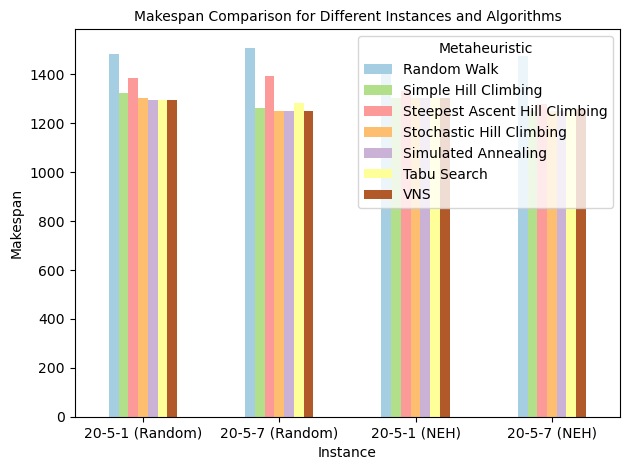

In [16]:
plt.figure(figsize=(16,8))
df.plot(kind='bar', colormap='Paired');

# Set plot labels and title
plt.xlabel('Instance')
plt.ylabel('Makespan')
plt.title('Makespan Comparison for Different Instances and Algorithms', fontsize=10)
plt.xticks(rotation=0)
plt.savefig('pop_meta.png')
plt.tight_layout()
plt.show()

### Remarks

- We implemented several methods for generating neighbors, and these methods has been used within algorithms such as SA and TS. Since the methods are different in complexity, the chosen method for these algorithm will have a significant impact on the execution time.
- We have tweaked the Tabu Search, compared to the version that we saw in the lecture.
- We acknowledge that hyperparameters have an impact on the resulting solution.

#### VNS Number of iterations

##### 100 iterations, 5 neighbors

In [253]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax = vns(neh_20_5_1, instance_1, 100, 5)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  0.200164794921875 seconds


##### 10000 iterations, 10 neighbors

In [255]:
print(f'NEH Solution: {neh_20_5_1}.')
print(f'Makespan: {cmax_20_5_1}')
start_time = time.time()
sol, Cmax = vns(neh_20_5_1, instance_1, 10000, 10)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")

NEH Solution: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19].
Makespan: 1334.0


Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19].
Makespan: 1305.0

Elapsed time:  21.224849700927734 seconds


**Observation**: For a small instance like this one with 20 jobs and 5 machines, VNS quickly reaches a very good solution, regardless of the initial solution.